# Example MNIST classifier

This notebook shows an example of model initialization, training and testing.

1. You first have to initialize your model by passing all configuration as parameters.
    - It will initialize all saving directories. 
    - Initializes the `tf.keras.Model` architecture (the actual model)
    - Save all configuration / weights in its directory (`pretrained_models/{model_name}`)
2. You can now *restore* your model just by calling the constructor with `nom = model_name`. 
    - It checks whether the model exists or not (if it has already been initialized). If yes, it will load all its saved configuration and load checkpoints
3. You have to **compile** your model : specify its loss, optimizer, metrics and their configuration. 
    - In theory, all these elements can be directly specified in your model's class `compile()` function, but arguments can still be useful if you want to modify the default optimizer / learning-rate.
3. Now your model is ready, you can load the training dataset with the `get_dataset()` function
4. Everything is ready, let's first check your dataset before training : it is really important to not train your model with corrupted / not correctly structured data !
5. Now that everything is okay, let's train ! Just call the `train` method with all configuration you want !\*
6. Now you can perform prediction with your model or compute its confusion matrix to make fancy plots ! :)

\* The `train` method is a custom training loop inspired by the official `fit` method with additional features. The `fit()` method is also available but some features are not well supported, such as multi loss / metrics (a single loss / metric returning multiple values) or custom `train_step` implementation.

Note that after the training is completed, model will be saved such that when you *restore* it, it will load the latest checkpoint.

*This repository is **not** an official classification repository, meaning that it is not integrated with the interfaces and thus many features are not available. It is an example of how to build, traing, restore and predict with the `BaseModel` class*

## Imports + model initialization

For the 1st model initialization, you have to pass all required configuration asargument to the constructor. 

After this creation, you **do not need** to repass them all the time ! just call its constructor with `nom = model_name` and all configuration will be automatically loaded !

In [12]:
import pandas as pd
import tensorflow as tf

from models import get_pretrained
from utils import set_display_options, plot, plot_multiple, plot_confusion_matrix
from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.classification import BaseClassifier

set_display_options()

model_name = 'mnist_classifier'
print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.10.0


In [2]:
input_shape = (28, 28, 1)
model = BaseClassifier(input_shape, labels = list(range(10)), nom = model_name)

print(model)

Initializing model with kwargs : {'classifier': {'architecture_name': 'simple_cnn', 'input_shape': (28, 28, 1), 'output_shape': 10, 'n_conv': 2, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'pooling': 'max', 'dense_as_final': True, 'n_dense': 1, 'dense_size': 64, 'final_activation': 'softmax', 'final_name': 'classification_layer', 'name': 'cnn_classifier'}}
Set `use_mask = False` by default as the masking operation is not supported. To remove this message or change the behavior, explicitely pass `use_mask = ...`
manual padding is not supported for conv_1 (reason : not supported for 2D yet)
manual padding is not supported for conv_2 (reason : not supported for 2D yet)
Initializing submodel : `classifier` !
Submodel classifier saved in pretrained_models\mnist_classifier\saving\classifier.json !
Model mnist_classifier initialized successfully !

========== mnist_classifier ==========
Sub model classifier
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 16
- Nu

## Model instanciation + dataset loading

As previously mentionned, once initialized, your model can be restored just by passing its name as argument. Furthermore, all models are `Singleton` such that if your model has already been restored, it will return the existing instance and will not restore it !

In [3]:
model = get_pretrained(model_name) # Equivalent to `BaseClassifier(nom = model_name)`

model.compile()

print(model)
model.summary()

Optimizer 'classifier_optimizer' initilized successfully !
Submodel classifier compiled !
  Loss : {'reduction': 'none', 'name': 'sparse_categorical_crossentropy', 'from_logits': False, 'ignore_class': None}
  Optimizer : {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : [{'name': 'sparse_categorical_accuracy', 'dtype': 'float32'}]

========== mnist_classifier ==========
Sub model classifier
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 16
- Number of parameters 	: 0.028 Millions
- Optimizer 	: {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
- Loss 	 : {'reduction': 'none', 'name': 'sparse_categorical_crossentropy', 'from_logits': False, 'ignore_class': None}
- Metrics	 : [{'name': 'sparse_categorical_accuracy', 'dtype': 'float32'}]

Already trained on 0 epochs (0 steps)

Labels : [0, 1, 2, 3, 4, 5,

In [4]:
ds = get_dataset('mnist')

train, valid = ds['train'], ds['test']
print(train)
print(valid)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


## Training + history analysis

Before training, I strongly recommand you to check your dataset by running the last cell of this notebook : it will run your dataset with the training configuration and outputs some statistics about batches. It can be useful to detect errors / unconsistencies / unexpected behaviour before training.

As you can see in the below cells, the `model.History` is a much more complex callback than the default one used in `keras` ! It keeps track of training configuration, time, statistics and logs for each step. 

PS : it is normal that there are 2 times `Epoch x / x` because the `train` function logs it and the `ProgressBarCallback` also.

In [5]:
model.train(
    train, validation_data = valid,
    epochs = 5, batch_size = 64,
    augment_prct = 0.25
)

Training config :
HParams :
- augment_prct	: 0.25
- batch_size	: 64
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 1024
- epochs	: 5
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1

Running on 1 GPU

Epoch 1 / 5
Epoch 1/5
938/938 [==============================] - 14s 12ms/step - loss: 1.7704 - sparse_categorical_accuracy: 0.8439 - val_loss: 1.4998 - val_sparse_categorical_accuracy: 0.9636

Saving at epoch 1 !

Making prediction at step 938

Epoch 2 / 5
Epoch 2/5
938/938 [==============================] - 10s 11ms/step - loss: 1.5287 - sparse_categorical_accuracy: 0.9399 - val_loss: 1.4891 - val_sparse_categorical_accuracy: 0.9728

Saving at epoch 2 !

Making prediction at step 1876

Epoch 3 / 5
Epoch 3/5
938/938 [==============================] - 13s 14ms/step - loss: 1.5131 - sparse_categorical_accuracy: 0.9518 - val_loss: 1.4822 - val_sparse_categorical_accuracy: 0.

===== History =====
       loss  sparse_categorical_accuracy  val_loss  val_sparse_categorical_accuracy
0  1.627845                     0.843883  1.499755                           0.9636
1  1.524254                     0.939900  1.489086                           0.9728
2  1.511874                     0.951767  1.482193                           0.9802
3  1.506272                     0.956383  1.483414                           0.9780
4  1.500093                     0.962383  1.478914                           0.9826


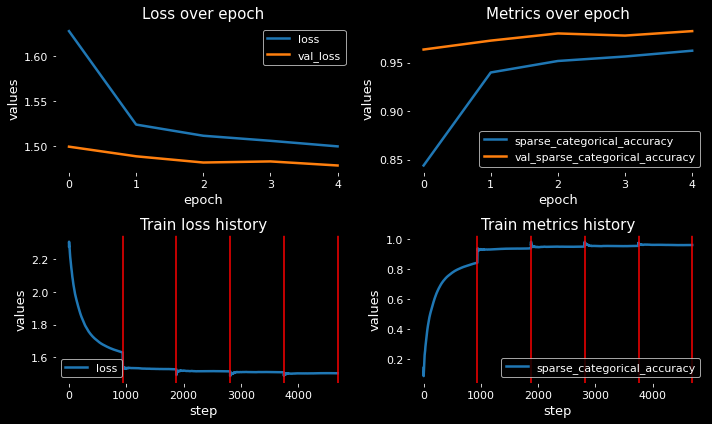

In [6]:
print(model.history)
model.plot_history()

In [7]:
print("Training config :")
print(pd.DataFrame(model.history.trainings_config))
print("\nTraining informations :")
print(pd.DataFrame(model.history.trainings_infos))


Training config :
                                             metrics                                             losses  \
0  {'name': 'metric_list', 'dtype': 'float32', 'm...  {'classifier_loss': {'reduction': 'none', 'nam...   

                                          optimizers  augment_prct  batch_size train_batch_size valid_batch_size  \
0  {'classifier_optimizer': {'name': 'Adam', 'lea...          0.25          64             None             None   

   test_batch_size  shuffle_size  epochs  verbose  train_times  valid_times train_size valid_size  test_size  pred_step  \
0                1          1024       5        1            1            1       None       None          4         -1   

                dataset_infos  
0  {'train': {}, 'valid': {}}  

Training informations :
                       start                        end       time  interrupted  start_epoch  final_epoch
0 2023-02-01 08:44:33.358597 2023-02-01 08:46:07.268104  93.909507        False           -1

**New feature** : the `History` class now tracks the configuration of metric(s), loss(es) and optimizer(s). It alos keeps track of a *dataset summary* but it is only supported for `pd.DataFrame` datasets (not supported for this training as it is a `tf.data.Dataset` class).

In [11]:
model.history.trainings_config[0]

{'metrics': {'name': 'metric_list',
  'dtype': 'float32',
  'metrics': [{'name': 'loss_metrics', 'dtype': 'float32'},
   {'name': 'sparse_categorical_accuracy', 'dtype': 'float32'}]},
 'losses': {'classifier_loss': {'reduction': 'none',
   'name': 'sparse_categorical_crossentropy',
   'from_logits': False,
   'ignore_class': None}},
 'optimizers': {'classifier_optimizer': {'name': 'Adam',
   'learning_rate': 0.001,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False}},
 'augment_prct': 0.25,
 'batch_size': 64,
 'train_batch_size': None,
 'valid_batch_size': None,
 'test_batch_size': 1,
 'shuffle_size': 1024,
 'epochs': 5,
 'verbose': 1,
 'train_times': 1,
 'valid_times': 1,
 'train_size': None,
 'valid_size': None,
 'test_size': 4,
 'pred_step': -1,
 'dataset_infos': {'train': {}, 'valid': {}}}

## Prediction

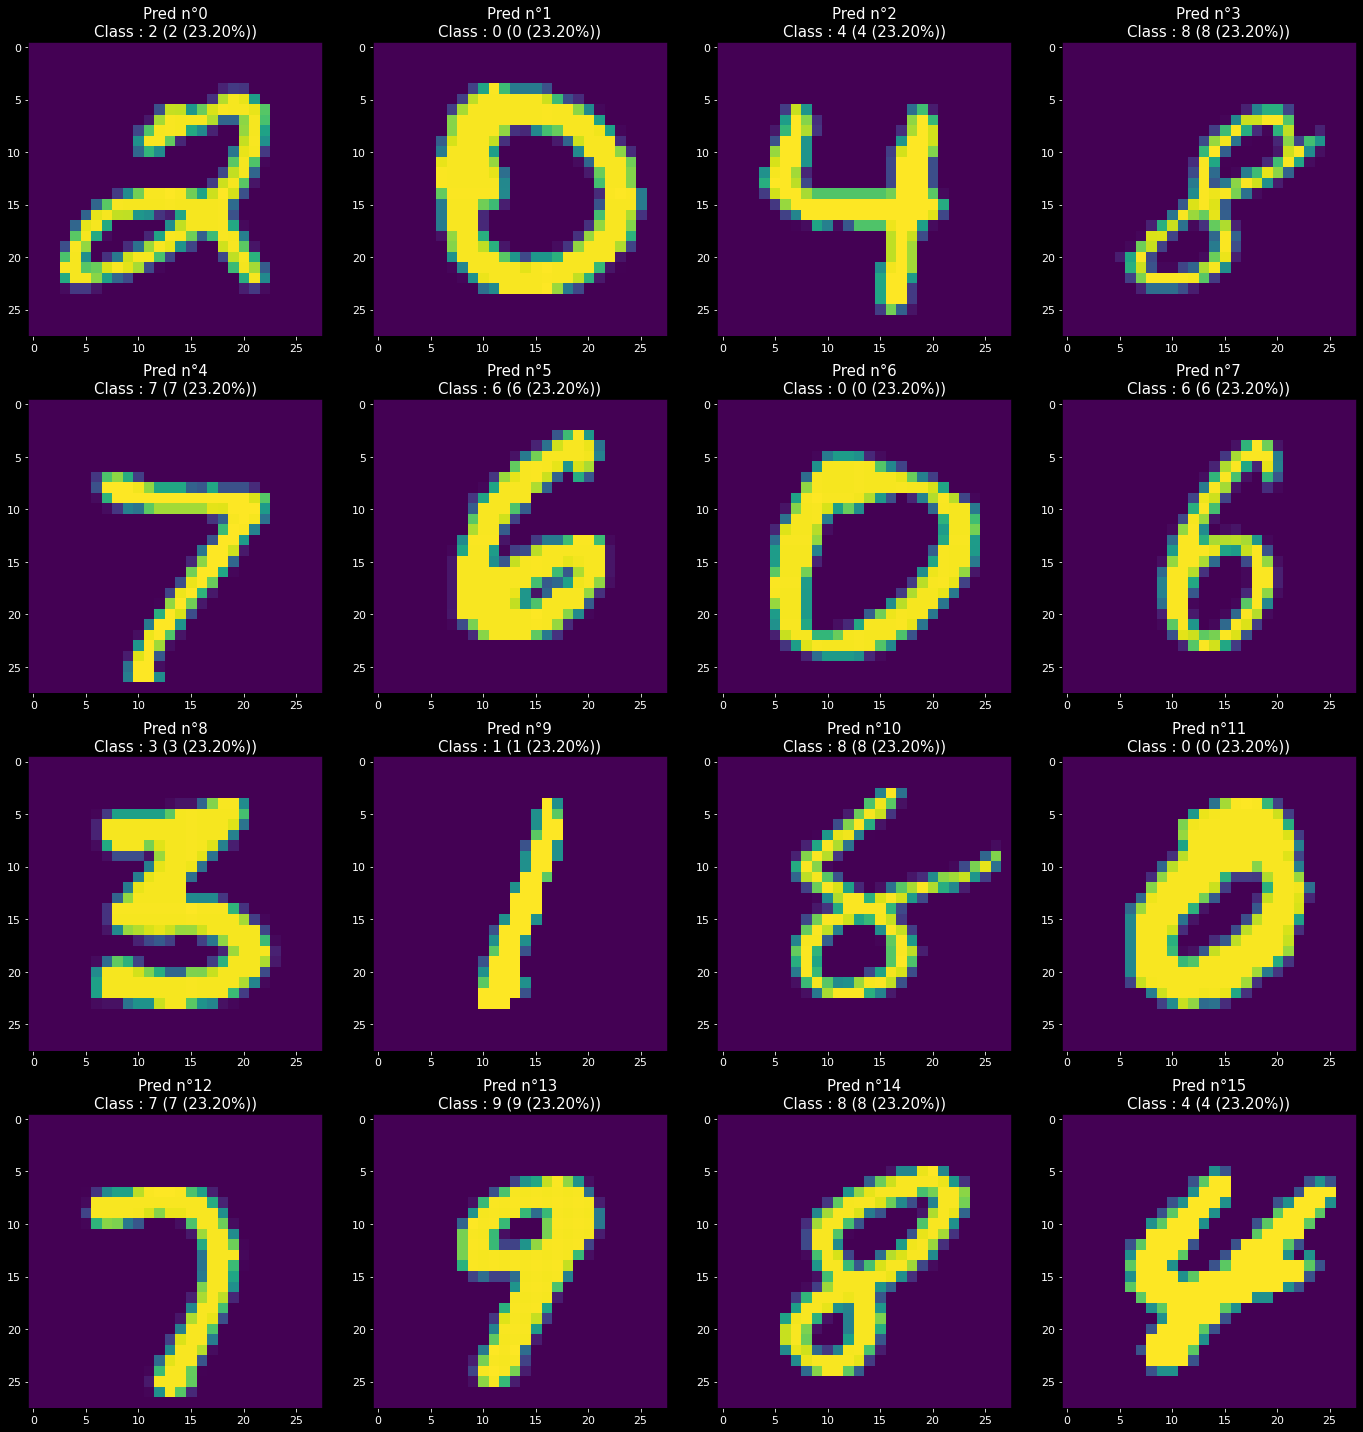

In [8]:
predictions = {}
for i, data in enumerate(valid):
    if i >= 16: break
    image, label = data['image'], data['label']
    
    pred, score = model.predict(image)[0]
    predictions['Pred n°{}\nClass : {} ({} ({:.2f}%))'.format(i, label, pred, score * 100)] = image

plot_multiple(** predictions, ncols = 4, plot_type = 'imshow')

## Confusion matrix

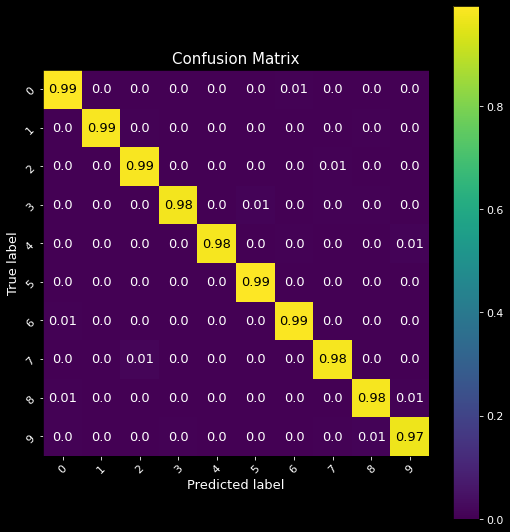

In [9]:
images, labels = [], []
for data in valid:
    images.append(data['image'])
    labels.append(data['label'])

pred = model.predict(images)
pred = [p[0] for p in pred] # p[1] is the confidence score

plot_confusion_matrix(true = labels, pred = pred, norm = True)

## Test dataset performance

These 3 lines allow you to debug your processing pipeline and test its performances

As you can see, the dataset correctly produces images of size `(28, 28, 1)` (grayscale) with values in range `[0, 1]`

**Important note** : the statistics are shown on the last generated batch. It is the reason why the 1st dimension (*batch_size*) do not corresponds to the actual `batch_size` argument because the dataset size is not a multiple of *64*.

In [10]:
from loggers import set_level

set_level('debug', 'datasets') # the 2nd argument tells to only set the `datasets.*` module to debug

config = model.get_dataset_config(is_validation = False, batch_size = 64)

ds_train = prepare_dataset(train, ** config)
test_dataset_time(ds_train, steps = 1000)

Original dataset : <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
- Dataset after mapping : <ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
- Dataset after batch : <BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 779.99it/s]


938 batchs in 1.210 sec sec (775.477 batch / sec)

Time estimated for all dataset (938 batch) : 202h 3min 17sec
Batch infos : 
Item 0 : shape : (32, 28, 28, 1) - type : float32- min : 0.000 - max : 1.000
Item 1 : shape : (32,) - type : int32- min : 0.000 - max : 9.000


1.209578514099121